In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox, Dropdown, Output
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
from IPython.display import display

import bs4 as bs
import requests
import yfinance as yf
import datetime

# Dynamic Conditional Correlation - What is it and why should you care?

In [2]:
def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

In [3]:
def garch_t_to_u(rets, res):
    mu = res.params['mu']
    nu = res.params['nu']
    est_r = rets - mu
    h = res.conditional_volatility
    std_res = est_r / h
    # we could also just use:
    # std_res = res.std_resid
    # but it's useful to see what is going on
    udata = t.cdf(std_res, nu)
    return udata

In [4]:
def loglike_norm_dcc_copula(theta, udata):
    N, T = np.shape(udata)
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata).T, ndmin=2)
    
    
    Rt, veclRt =  dcceq(theta,trdata)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[:,:,i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[i,:] , (np.linalg.inv(Rt[:,:,i]) - np.eye(N))) ,trdata[i,:].T)
    llf = np.sum(llf)

    return -llf

In [5]:
def dcceq(theta,trdata):
    T, N = np.shape(trdata)

    a, b = theta
    
    if min(a,b)<0 or max(a,b)>1 or a+b > .999999:
        a = .9999 - b
        
    Qt = np.zeros((N, N ,T))

    Qt[:,:,0] = np.cov(trdata.T)

    Rt =  np.zeros((N, N ,T))
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    
    Rt[:,:,0] = np.corrcoef(trdata.T)
    
    for j in range(1,T):
        Qt[:,:,j] = Qt[:,:,0] * (1-a-b)
        Qt[:,:,j] = Qt[:,:,j] + a * np.matmul(trdata[[j-1]].T, trdata[[j-1]])
        Qt[:,:,j] = Qt[:,:,j] + b * Qt[:,:,j-1]
        Rt[:,:,j] = np.divide(Qt[:,:,j] , np.matmul(np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2)).T , np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2))))
    
    for j in range(0,T):
        veclRt[j, :] = vecl(Rt[:,:,j].T)
    return Rt, veclRt

In [8]:
model_parameters = {}
udata_list = []

def run_garch_on_return(rets, udata_list, model_parameters):
    for x in rets:
        am = arch_model(rets[x], dist = 't')
        short_name = x.split()[0]
        model_parameters[short_name] = am.fit(disp='off')
        udata = garch_t_to_u(rets[x], model_parameters[short_name])
        udata_list.append(udata)
    return udata_list, model_parameters

## Initially run GARCH on the individual time series, and transform them to the uniform distribution

In [9]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020,12,30)

In [10]:
close_prices = yf.download(tickers, start=start, end=end)['Adj Close']

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- OGN: Data doesn't exist for startDate = 1262264400, endDate = 1609246800


In [11]:
rets = ((close_prices / close_prices.shift(1)) - 1 ).dropna(how='all') * 100

In [12]:
udata_list, model_parameters = run_garch_on_return(rets.iloc[:,:5].dropna(), udata_list, model_parameters)

## Setup our DDC Model, and then run it on our 5 securities

In [24]:
rets.tail()

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2020-12-21 -1.274095 -2.483342  0.312511  1.239535 -0.708474 -0.953246   
2020-12-22 -0.348099 -3.850937 -0.679164  2.846445 -0.877444 -0.972677   
2020-12-23 -0.059649  2.648584 -0.069011 -0.697590  0.466919  0.537632   
2020-12-24  0.008524 -1.447454  0.872613  0.771207 -0.019361 -0.277652   
2020-12-28  0.443271  2.554276 -1.170018  3.576578  0.183995 -0.175310   

                ABMD       ABT       ACN      ADBE  ...       XEL      XLNX  \
Date                                                ...                       
2020-12-21  0.824835 -0.807564 -1.814061 -0.906650  ... -1.074131 -2.620822   
2020-12-22  2.204114  0.175782 -0.745944  1.159734  ... -0.200122 -0.770922   
2020-12-23  0.568915 -0.766526 -0.782360 -1.439992  ... -0.802105 -1.505271   
2020-12-24 -0.210486  0.837591 -0.054388  0.593665  ...  0.497597  0.000000   
2020-12-28  3.131077 -0.516836  0.924989 -0.182046  ...  1.067604 -0.331010   

                 XOM      XRAY       XYL       YUM       ZBH      ZBRA  \
Date                                                                     
2020-12-21 -1.825404 -0.304181  0.669671 -1.047559 -2.140257  0.780162   
2020-12-22 -1.692493 -1.201367 -1.310578 -1.132274  1.500663  1.077382   
2020-12-23  1.285161 -0.193394  0.331999 -0.567980 -1.226548 -0.057901   
2020-12-24 -0.406999  0.406901  0.521408  0.702322  0.342872 -0.750507   
2020-12-28  0.336540  0.945582  0.119702  2.082946 -0.241203  1.512373   

                ZION       ZTS  
Date                            
2020-12-21  3.286268 -1.705070  
2020-12-22 -0.919160  0.615517  
2020-12-23  3.496668 -1.223503  
2020-12-24 -0.390709  0.544255  
2020-12-28  0.046144  1.039080  

[5 rows x 505 columns]

In [32]:
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.5), (0, 0.9997))

In [36]:
%time opt_out = minimize(loglike_norm_dcc_copula, [0.01, 0.95], args = (udata_list,), bounds=bnds, constraints=cons)

Wall time: 7.17 s


In [37]:
print(opt_out.success)
print(opt_out.x)

True
[0.00901478 0.92777558]


In [14]:
llf  = loglike_norm_dcc_copula(opt_out.x, udata_list)
llf

-749.6177406713527

In [15]:
trdata = np.array(norm.ppf(udata_list).T, ndmin=2)
Rt, veclRt = dcceq(opt_out.x, trdata)

In [16]:
stock_names = [x.split()[0] for x in rets.iloc[:,:5].columns]

In [17]:
corr_name_list = []
for i, name_a in enumerate(stock_names):
    if i == 0:
        pass
    else:
        for name_b in stock_names[:i]:
            corr_name_list.append(name_a + "-" + name_b)

## ABBV (AbbVie) and A (Agilent Technologies) Look interesting

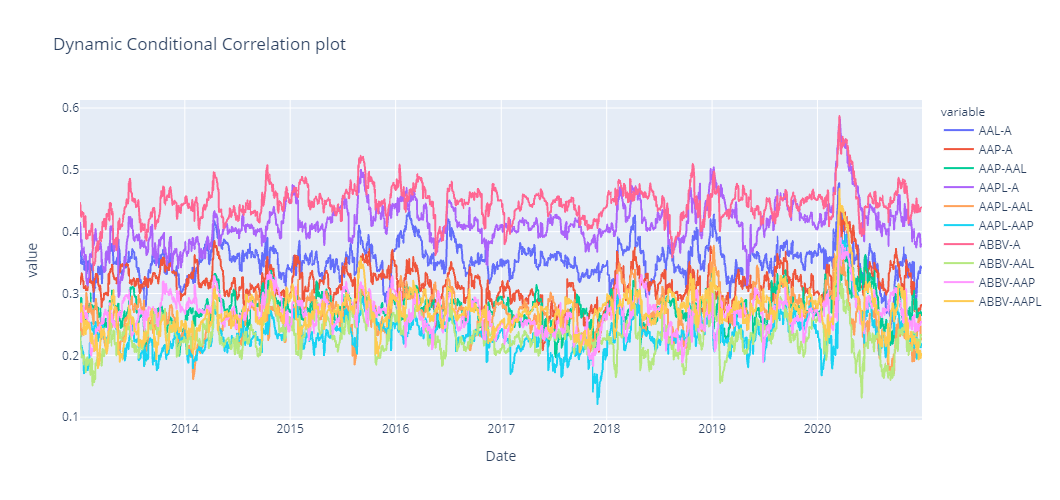

In [31]:
dcc_corr = pd.DataFrame(veclRt, index = rets.iloc[:,:5].dropna().index, columns= corr_name_list)
dcc_plot = px.line(dcc_corr, title = 'Dynamic Conditional Correlation plot', width=1000, height=500)
dcc_plot.show()

In [19]:
garch_vol_df = pd.concat([pd.DataFrame(model_parameters[x].conditional_volatility/100)*1600 for x in model_parameters], axis=1)
garch_vol_df.columns = stock_names

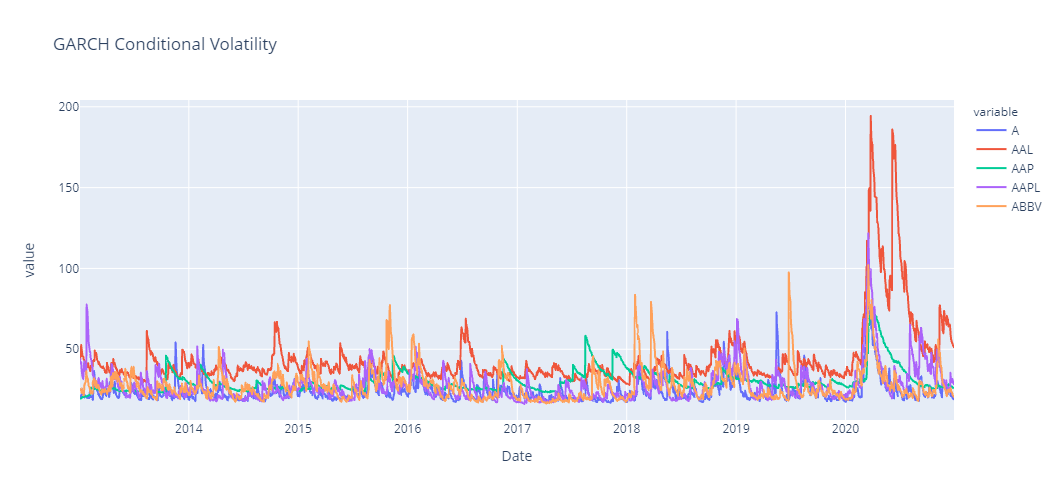

In [20]:
px.line(garch_vol_df, title='GARCH Conditional Volatility', width=1000, height=500).show()

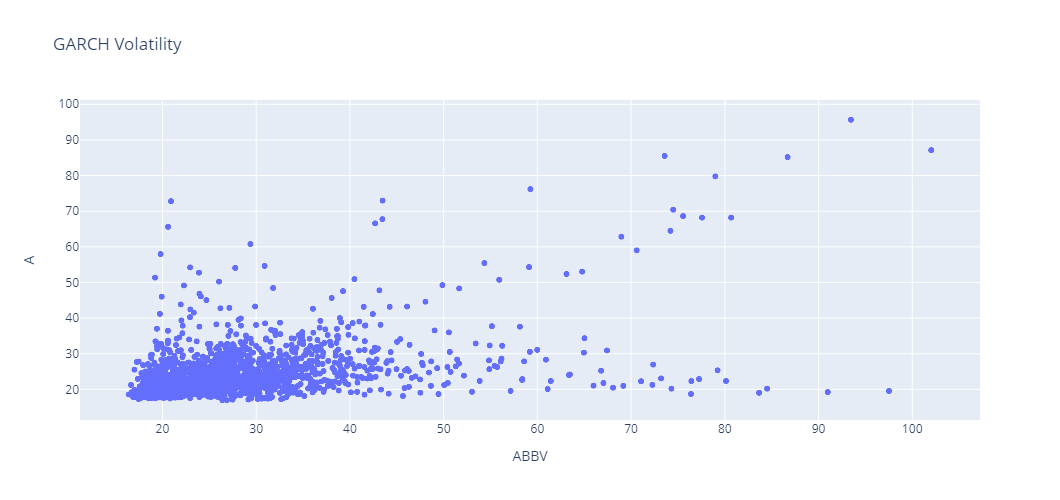

In [21]:
px.scatter(garch_vol_df, x = 'ABBV', y='A', width=1000, height=500, title='GARCH Volatility').show()

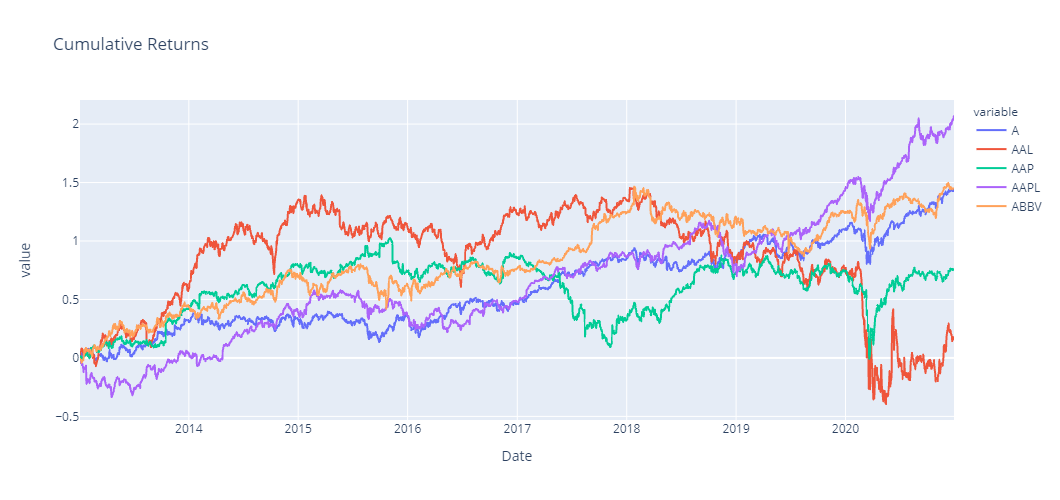

In [22]:
px.line(np.log((1+rets.iloc[:,:5].dropna()/100).cumprod()), title='Cumulative Returns', width=1000, height=500).show()

In [23]:
rets.loc[:, ['ABBV','A']].corr()

ABBV         A
ABBV  1.000000  0.435699
A     0.435699  1.000000

In [24]:
def update_corr_data(change):
    a1corr = rets.loc[:, pair_dropdown.value.split('-')].corr().values[0][1]
    a1dcc = pd.DataFrame(veclRt[:,corr_name_list.index(pair_dropdown.value)],index = rets.iloc[:,:5].dropna().index)
    a1dcc.columns = ['DCC']
    a1dcc['corr'] = a1corr
    corr_line_plot = px.line(a1dcc, title = 'DCC vs unconditional correlation for ' + pair_dropdown.value, width=1000, height=500)
    output_graphics.clear_output()
    with output_graphics:
        display(corr_line_plot)

In [25]:
output_graphics = Output()
pair_dropdown = Dropdown(options=[''] + corr_name_list)
pair_dropdown.observe(update_corr_data, 'value')
VBox([pair_dropdown, output_graphics])